<table align="left">
  <td>
    <a href="https://tinyurl.com/2qvvet2y" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# Redes Neuronales - Clasificación con TensorFlow

Un problema de clasificación es un problema de aprendizaje supervisado en cual se busca predecir si un ejemplo pertenece a una clase o a otra.

Tipos de problemas de clasificación:

* **Clasificación binaria**: Dos clases
* **Clasificación multiclase**: Más de dos clases
* **Clasificación multietiqueta**: Cada ejemplo puede pertenecer a más de una clase

Ejemplos de problemas de clasificación son:

- Dado un correo electrónico, predecir si es spam o no.
- Dado un tumor, predecir si es maligno o benigno.
- Decidir si una imagen contiene comida, un gato o un perro.
- Dado un tweet, predecir si es positivo o negativo.
- Predecir que categoría se le debe asignar a un artículo de Wikipedia.

En este notebook se abordarán los siguientes temas:

- Arquitectura de un modelo de clasificación con TensorFlow.
- Shapes de entrada y salida.
    - X: matriz de características.
    - Y: matriz de etiquetas.
        - A que clase pertenece cada ejemplo.
- Crear datos personalizados para observar y entender el funcionamiento de un modelo de clasificación.
- Pasos para crear un modelo para clasificación binaria y multiclase.
    - Crear un modelo
    - Compilar el modelo
        - Definir la función de pérdida
        - Definir el optimizador
          - Encontrar la mejor tasa de aprendizaje
        - Definir las métricas
    - Entrenar el modelo
    - mejorar el modelo
- El poder de la no linealidad
- Evaluación de modelos de clasificación
    - Visualización del modelo
    - Observar curvas de entrenamiento y validación
    - Comparar predicciones con etiquetas reales 

## Arquitectura de un modelo de clasificación con TensorFlow


<a href="https://ibb.co/c8Rxz4Y"><img src="https://i.ibb.co/mydSQfN/imagen-2022-12-05-101854167.png" alt="nn_class" border="0"></a>
<a href=""><img src="https://tinyurl.com/2h2em9u8" alt="nn_class" border="0"></a>

## Creando Datos para observar y entrenar un modelo de clasificación

In [42]:
import tensorflow as tf
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import numpy as np
# Make 1000 examples
n_samples = 1000

# Create circles

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

# Check out the data
X[:5], y[:5]


(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0], dtype=int64))

In [25]:
import pandas as pd

circles = pd.DataFrame({"X0": X[:, 0], "X1": X[:, 1], "label": y})
circles.head()

,X0,X1,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [26]:
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

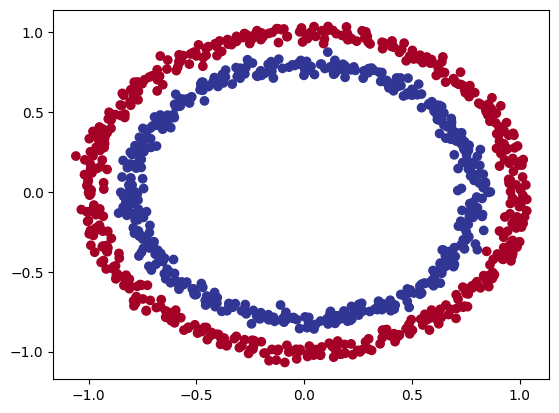

In [28]:
# View the data
# X0 = feature 0, X1 = feature 1, label = target
# 0 = blue, 1 = red
# X[:, 0] = all rows, first column
# X[:, 1] = all rows, second column

plt.scatter(x = X[:, 0], y= X[:, 1], c=y, cmap=plt.cm.RdYlBu);

## Shapes de entrada y salida

In [29]:
# check out the shapes of X and y
X.shape, y.shape

((1000, 2), (1000,))

## Crear un modelo de clasificación

In [30]:
from sklearn.model_selection import train_test_split

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 2), (200, 2), (800,), (200,))

In [63]:
# Set random seed
tf.random.set_seed(42)

# 1. Crear un modelo usando la API secuencial

model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation="relu", input_shape=(X[0].shape)),
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# 2. Compilar el modelo

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 3. Ajustar el modelo
history = model.fit(X_train, y_train, epochs=100, verbose=0)

<Figure size 400x400 with 0 Axes>

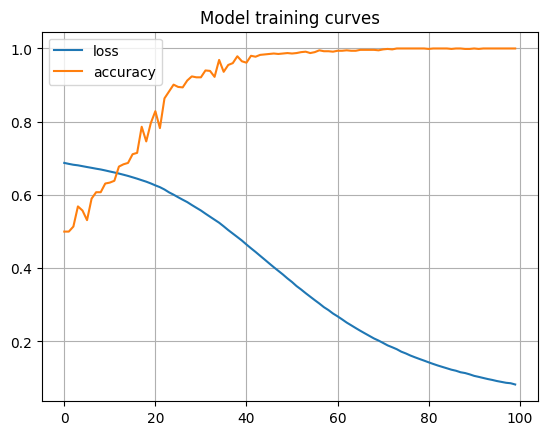

In [73]:
# Plot the loss curves
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.title("Model training curves");


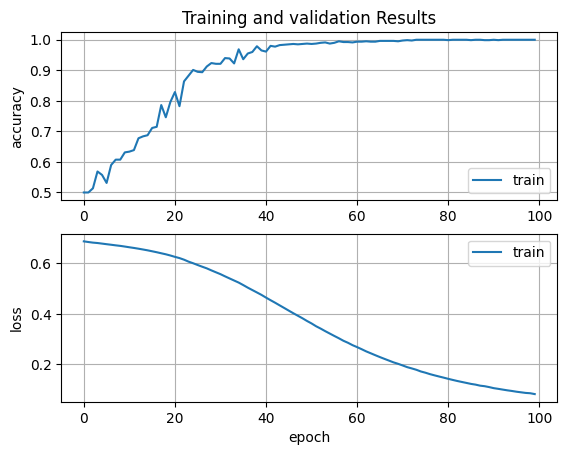

In [65]:
plt.subplot(211)
plt.title('Training and validation Results')
plt.plot(history.history['accuracy'])  
plt.ylabel('accuracy')  
plt.legend(['train'], loc='lower right')
plt.grid(True)

 # summarize history for loss  
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train'], loc='upper right')  
plt.grid(True)

plt.show()  


In [66]:
scores_train = model.evaluate(X_train, y_train, verbose=0)
scores_test = model.evaluate(X_test, y_test, verbose=0)

In [67]:
print('train loss:', round(scores_train[0]*100,2), '%')
print('test loss:', round(scores_test[0]*100,2), '%')

print('train accuracy:', round(scores_train[1]*100,2), '%')
print('test accuracy:', round(scores_test[1]*100,2), '%')

train loss: 8.05 %
test loss: 11.52 %
train accuracy: 100.0 %
test accuracy: 100.0 %


In [57]:
# plot decision boundary
def plot_decision_boundary(model, X, y):
  """
  Plots the decision boundary created by a model predicting on X.
  This function has been adapted from two phenomenal resources:
   1. CS231n - https://cs231n.github.io/neural-networks-case-study/
   2. Made with ML basics - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb
  """
  # Define the axis boundaries of the plot and create a meshgrid
  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                       np.linspace(y_min, y_max, 100))
  
  # Create X values (we're going to predict on all of these)
  x_in = np.c_[xx.ravel(), yy.ravel()] # stack 2D arrays together: https://numpy.org/devdocs/reference/generated/numpy.c_.html
  
  # Make predictions using the trained model
  y_pred = model.predict(x_in)

  # Check for multi-class
  if model.output_shape[-1] > 1: # checks the final dimension of the model's output shape, if this is > (greater than) 1, it's multi-class 
    print("doing multiclass classification...")
    # We have to reshape our predictions to get them ready for plotting
    y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
  else:
    print("doing binary classifcation...")
    y_pred = np.round(np.max(y_pred, axis=1)).reshape(xx.shape)
  
  # Plot decision boundary
  plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

doing binary classifcation...


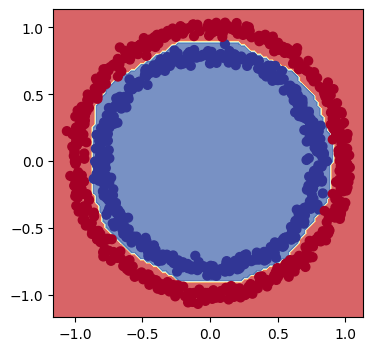

In [72]:
plt.figure(figsize=(4, 4))
plot_decision_boundary(model=model, X=X, y=y)

doing binary classifcation...
doing binary classifcation...


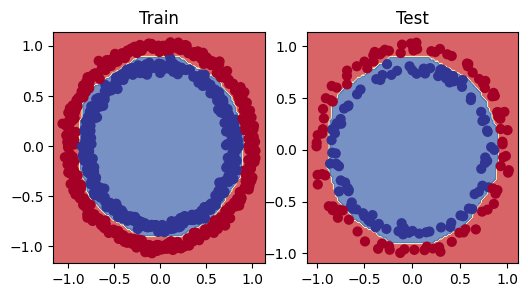

In [70]:
# Plot the decision boundaries for the training and test sets
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X=X_test, y=y_test)
plt.show()

## Encontrar la mejor tasa de aprendizaje

La tasa de aprendizaje es un hiperparámetro que controla la velocidad a la que el modelo aprende. 